Now I will use the pre-trained model **VGG16**, a very deep convolutional networks used for Large-Scale Image Recognition tasks. 

The model is trained for 10 epochs with batch size of 256, compiled with `categorical_crossentropy` loss function and `Adam` optimizer.

## Data Processing
* First loading the training and test data from csv files.

In [1]:
import numpy as np 
import pandas as pd 
import os, time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os

Using TensorFlow backend.


### Loading the dataset from raw csv files.


In [2]:
train_data = pd.read_csv('dataset/fashion-mnist_train.csv')
test_data = pd.read_csv('dataset/fashion-mnist_test.csv')

In [3]:
train_data.shape
test_data.shape 
train_X= np.array(train_data.iloc[:,1:])
test_X= np.array(test_data.iloc[:,1:])
train_Y= np.array (train_data.iloc[:,0])
test_Y = np.array(test_data.iloc[:,0])

In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_X.shape, test_X.shape

((60000, 784), (10000, 784))

In [6]:
classes = np.unique(train_Y)
num_classes = len(classes)
num_classes

10

The images of fashionMNIST are black and white, while the required input for VGG19 must be colored images. Thus, I convert the images into colored ones with 3 channels R, G, B.

In [7]:
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
train_X.shape,test_X.shape

((60000, 784, 3), (10000, 784, 3))

### Reshaping images as per the tensor format required by tensorflow


In [8]:
# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [9]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [10]:
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [11]:
# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

### Converting Labels to one hot encoded format


In [12]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

### Splitting train data as train and validation data


In [13]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [14]:
# Finally check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

#### Defining the parameters for instanitaing VGG16 model. 


In [15]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

#### Preprocessing the input 


In [16]:
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

### VGG-16 From Keras Library
I passed 3 arguments to the constructor:
* `weights` specifies the weight checkpoint from which to initialize the model.
* `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because I intend to use my own densely connected classifier (with only 10 classes), I don’t need to include it.
* `input_shape`: optional shape tuple, only to be specified if `include_top` is False.

Here's the detail of the architecture of the VGG16 convolutional base.

In [17]:
conv_base = keras.applications.vgg16.VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
bloc

## Training the Model
As previously mentioned, I will train the model using batch sizes and 10 epochs on both training and validation data.

* Extracting features

In [18]:
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)

12000/12000 [==============================] - 201s 17ms/step


* Save the features so that they can be used for future

In [19]:
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

* Shape of features

In [20]:
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [21]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [22]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

##### Define the densely connected classifier followed by leakyrelu layer and final dense layer for the number of classes


In [23]:
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

##### Compiling the model.

In [24]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

##### Reduced learning and Early stopping for callback Implementation


In [25]:
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

C:\Users\Vinci\Anaconda3\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [26]:
# Train the Model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 5s 103us/step - loss: 2.4352 - acc: 0.0986 - val_loss: 2.3898 - val_acc: 0.1040
Epoch 2/100
48000/48000 [==============================] - 5s 97us/step - loss: 2.3460 - acc: 0.1018 - val_loss: 2.3564 - val_acc: 0.0987
Epoch 3/100
48000/48000 [==============================] - 5s 94us/step - loss: 2.3126 - acc: 0.1000 - val_loss: 2.3028 - val_acc: 0.1040
Epoch 4/100
48000/48000 [==============================] - 4s 92us/step - loss: 2.3028 - acc: 0.1008 - val_loss: 2.3028 - val_acc: 0.0946
Epoch 5/100
48000/48000 [==============================] - 4s 93us/step - loss: 2.3028 - acc: 0.0996 - val_loss: 2.3028 - val_acc: 0.0946

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/100
48000/48000 [==============================] - 4s 94us/step - loss: 2.3026 - acc: 0.1014 - val_loss: 2.3028 - val_acc

## Plots of Loss and Accuracy

* Plotting the Loss and Accuracy graphs

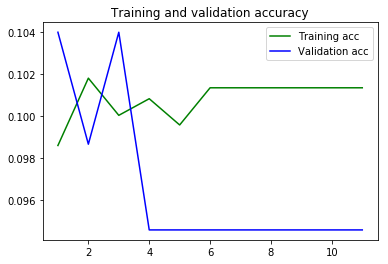

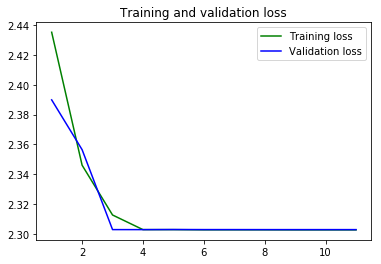

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()